In [1]:
#making distribution plots for each score type (with fixed pull sizes per dimer)
#ran Ala scan on all dimers in test set- looking at top score values vs others in permutation tests 

import time
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns 


In [7]:
def createScoresDictionary(fileName, fileDir):
    #names are too long, varied, and sizes shift too much.
    #created shortened names in a text file to map both binder 1 & binder 2 scores to these shorthand names
    #fixes up sizes -> either (480,81) or (200, 81) sized score arrays now
    keys = open(fileName, "r")
    keyPairs = [x.strip().split(",") for x in keys.readlines()]
    dictScores = {}
    for pair in keyPairs:
        k = pair[1]
        if k in dictScores:
            dictScores[k].append(pair[0])
        else:
            dictScores[k] = [pair[0]]
    #sort key pairs in dict
    for thing in dictScores:
        dictScores[thing].sort()

    for thing in dictScores:
        #load both, check sizes, look at first row of each
        scores1 = np.load(fileDir + dictScores[thing][0])
        scores2 = np.load(fileDir + dictScores[thing][1])
        #print (scores1.shape)
        #print (scores2.shape)
        #need to sum, then reshape off the 1's
        if scores1.shape[-1] == 20:
            # if shape is (x,1,81,20) -> sum along 20 columns for scores
            # (x,1,81,20) -> (x,1,81,1) -> (x,81)
            sumCol1 = np.reshape(scores1.sum(axis = 3), (scores1.shape[0], 81)) #sum all 20 values
            sumCol2 = np.reshape(scores2.sum(axis=3), (scores2.shape[0], 81))  # sum all 20 values
            #add to dict list
            #print (sumCol1.shape)
            dictScores[thing].append(sumCol1)
            dictScores[thing].append(sumCol2)
        elif scores1.shape[-1] == 1 and len(scores1.shape) != 2:
            # if scores are (x,1,81,1) -> (x,1) (should be able to reshape)
            collapsed = np.reshape(scores1, (scores1.shape[0], 81))
            collapsed2 = np.reshape(scores2, (scores2.shape[0], 81))
            #print(collapsed.shape)
            dictScores[thing].append(collapsed)
            dictScores[thing].append(collapsed2)
        else:
            #do nothing
            #print (scores1.shape)
            dictScores[thing].append(scores1)
            dictScores[thing].append(scores2)
    return dictScores

    
def recalcPValue(npyAll):
    #calculates permutation test p value again
    #position -1 is the actaul mean value for the test
    #other positions are the permutations 
    actualMean = npyAll[-1]
    allMeans = npyAll[:-1]
    pValue = (sum(allMeans >= actualMean) + 1) / (allMeans.shape[0] + 1)
    return pValue

In [8]:


def makePermutationTestGraphs(output_csv_name):
    #make the permutation test graphs for all measures characteristics of the dimers 
    #save csv of permutation value means and p-values
    
    csvName = "test_set.csv"
    scoresCSV = pd.read_csv(csvName)
    fileDir = "./coiled_coil_binder_scores/"
    scoresCSV = pd.read_csv(csvName)
    dictScores = createScoresDictionary("all_scored_methods.txt", fileDir) #checks out, sorted to binder 1, binder 2 order for the scores in the dict
   
    #print (dictScores)
    start = time.time()
    asDF = {'Model':[], 'DimerN':[],'ddGMean':[], 'ddGPValue':[], 'HBondMeanDifference':[], 'HBondPValue':[], 'HBondUnsatMeanDiff':[], 'HBondUnsatPValue':[], 'HBondEnFractionMeanDiff':[], 'HBondEnFractionPValue':[]}
    toPlot = []
    colorPlot = []
    toPlotddG = None
    toPlotHB = None
    toPlotHBU = None
    
    for thing in dictScores:
        print (thing)
        if "inclusion" in thing or 'occlusion' in thing or 'tb' in thing:
           #autoscrambler 
            if "inclusion" in thing:
                colorPlot.append("--r")
            else:
                colorPlot.append("--b")
        else:
            colorPlot.append("--g")

        print ("ON: ", thing, "OUT OF: ", len(dictScores))
        scores1 = dictScores[thing][2]
        scores2 = dictScores[thing][3]
        asDF['Model'].append(thing)
        asDF['DimerN'].append(scores1.shape[0])

        ddGName = "./outputV2/" +  thing + "_top_" + str(8)   + "_ " + str(10000) + "_ddG_permutation_test.npy"
        ddGValues = np.load(ddGName)
        asDF['ddGMean'].append(ddGValues[-1])
        toPlotddG = ddGValues[:-1] #keeping the last ddG histogram seen to make plots with 
        asDF['ddGPValue'].append(recalcPValue(ddGValues))

        hbondName = "./outputV2/" +  thing + "_top_" + str(8)   + "_ " + str(10000) + "_hbonds_permutation_test.npy"
        hbondValues = np.load(hbondName)
        toPlotHB = hbondValues[:-1]
        asDF['HBondMeanDifference'].append(hbondValues[-1])
        asDF['HBondPValue'].append(recalcPValue(hbondValues))

        hbondUnsatName = "./outputV2/" +  thing + "_top_" + str(8)   + "_ " + str(10000) + "_unsat_hbonds_permutation_test.npy"
        hbondUnsatValues = np.load(hbondUnsatName)
        toPlotHBU = hbondUnsatValues[:-1]
        asDF['HBondUnsatMeanDiff'].append(hbondUnsatValues[-1])
        asDF['HBondUnsatPValue'].append(recalcPValue(hbondUnsatValues))

        hbondEnName = "./outputV2/" +  thing + "_top_" + str(8)   + "_ " + str(10000) + "_en_hbonds_permutation_test.npy"
        hbondEnValues = np.load(hbondEnName)
        asDF['HBondEnFractionMeanDiff'].append(hbondEnValues[-1])
        asDF['HBondEnFractionPValue'].append(recalcPValue(hbondEnValues))
        
    asDF = pd.DataFrame(asDF)
    
    print (colorPlot)
    plt.hist(toPlotddG)
    ylim = plt.ylim()
    for ind, row in asDF.iterrows():
        name = row['Model']
        n = row['DimerN']
        mean = row['ddGMean']
        plt.plot([mean, mean], ylim, colorPlot[ind], linewidth=1.5,
                 label=name)
    plt.ylim(ylim)
    #plt.legend()
    plt.xlabel('Mean Differences')
    plt.title('ddG Mean Difference Permutation Tests')
    plt.show()
    
    
    plt.hist(toPlotHB)
    ylim = plt.ylim()
    for ind, row in asDF.iterrows():
        name = row['Model']
        n = row['DimerN']
        mean = row['HBondMeanDifference']
        plt.plot([mean, mean], ylim, colorPlot[ind], linewidth=1.5,
                 label=name)
    plt.ylim(ylim)
    #plt.legend()
    plt.xlabel('Mean Differences')
    plt.title('Mean Delta Interface H-Bond Difference Permutation Tests')
    plt.show()
    
    
    plt.hist(toPlotHBU)
    ylim = plt.ylim()
    for ind, row in asDF.iterrows():
        name = row['Model']
        n = row['DimerN']
        mean = row['HBondUnsatMeanDiff']
        plt.plot([mean, mean], ylim, colorPlot[ind], linewidth=1.5,
                 label=name)
    plt.ylim(ylim)
    #plt.legend()
    plt.xlabel('Mean Differences')
    plt.title('Mean Delta Interface Unsatisified H-Bond Difference Permutation Tests')
    plt.show()
    #plotting the kept values 
    
    #plotting delta H-bonds & delta H-Bonds Unsat 
    plt.scatter(asDF['HBondMeanDifference'].to_list(), asDF['HBondUnsatMeanDiff'])
    plt.xlabel("Mean Interface H-Bond Difference")
    plt.ylabel("Mean Interface Unsatisfied H-Bond Difference")
    plt.show()
    
    asDF.to_csv(output_csv_name)



(480, 81)
(480, 81)
(480, 81)
(480, 81)
(480, 81)
(480, 81)
(480, 81)
(480, 81)
(480, 81)
(480, 81)
(480, 81)
(480, 81)
(480, 81)
(480, 81)
(480, 81)
(480, 81)
(480, 81)
(480, 81)
(480, 81)
(480, 81)
(480, 81)
(480, 81)
(480, 81)
(480, 81)
(480, 81)
(480, 81)
(480, 1, 81, 20)
(480, 1, 81, 20)
(480, 1, 81, 20)
(480, 1, 81, 20)
(480, 81)
(480, 81)
(480, 81)
(480, 81)
(480, 81)
(480, 81)
(480, 81)
(480, 81)
(480, 81)
(480, 81)
(480, 81)
(480, 81)
(480, 81)
(480, 81)
(480, 81)
(480, 81)
(480, 81)
(480, 81)
(480, 81)
(480, 81)
(480, 81)
(480, 81)
(480, 81)
(480, 81)
(480, 81)
(480, 81)
(480, 1, 81, 20)
(480, 1, 81, 20)
(480, 1, 81, 20)
(480, 1, 81, 20)
(480, 1, 81, 20)
(480, 1, 81, 20)
(480, 1, 81, 20)
(480, 1, 81, 20)
(480, 1, 81, 1)
(480, 1, 81, 1)
(480, 81)
(480, 81)
(480, 81)
(480, 81)
(480, 1, 81, 20)
(480, 1, 81, 20)
(480, 1, 81, 20)
(480, 1, 81, 20)
(480, 1, 81, 20)
(480, 1, 81, 20)
(480, 81)
(480, 81)
(480, 81)
(480, 81)
(480, 1, 81, 20)
(480, 1, 81, 20)
(480, 1, 81, 20)
(480, 1, 81

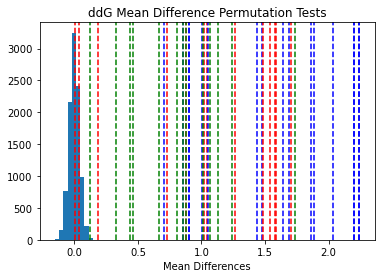

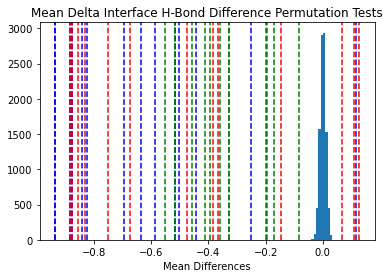

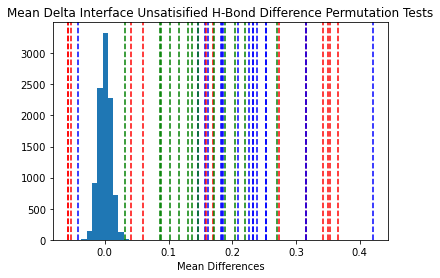

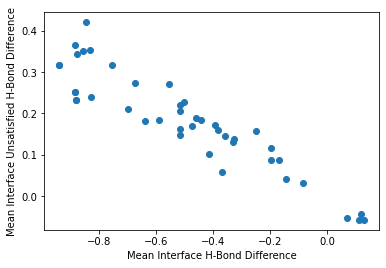

In [9]:
makePermutationTestGraphs("permutation_test_values.csv")